# Particle Swarm Optimization

## Introduction

Particle Swarm Optimization (PSO) is a computational method that optimizes a problem by iteratively improving candidate solutions with regard to a given measure of quality. Introduced by Kennedy and Eberhart in 1995, PSO is inspired by the social behavior of bird flocking and fish schooling.

PSO belongs to the class of metaheuristic optimization algorithms and is particularly effective for continuous nonlinear optimization problems where gradient information is unavailable or unreliable.

## Mathematical Formulation

### Particle Representation

Consider a swarm of $N$ particles in a $D$-dimensional search space. Each particle $i$ is characterized by:

- **Position vector**: $\mathbf{x}_i = (x_{i1}, x_{i2}, \ldots, x_{iD})$
- **Velocity vector**: $\mathbf{v}_i = (v_{i1}, v_{i2}, \ldots, v_{iD})$
- **Personal best position**: $\mathbf{p}_i = (p_{i1}, p_{i2}, \ldots, p_{iD})$

The swarm also maintains a **global best position**:
$$\mathbf{g} = (g_1, g_2, \ldots, g_D)$$

### Velocity and Position Update Equations

At each iteration $t$, the velocity and position of each particle are updated according to:

$$v_{id}^{(t+1)} = w \cdot v_{id}^{(t)} + c_1 r_1 (p_{id} - x_{id}^{(t)}) + c_2 r_2 (g_d - x_{id}^{(t)})$$

$$x_{id}^{(t+1)} = x_{id}^{(t)} + v_{id}^{(t+1)}$$

where:
- $w$ is the **inertia weight** controlling the influence of previous velocity
- $c_1$ is the **cognitive coefficient** (personal learning factor)
- $c_2$ is the **social coefficient** (global learning factor)
- $r_1, r_2 \sim \mathcal{U}(0, 1)$ are random numbers drawn from uniform distribution

### Inertia Weight Strategies

A common approach is to use a **linearly decreasing inertia weight**:

$$w^{(t)} = w_{\max} - \frac{(w_{\max} - w_{\min}) \cdot t}{T_{\max}}$$

where $T_{\max}$ is the maximum number of iterations. This strategy promotes exploration in early iterations and exploitation in later iterations.

### Personal and Global Best Updates

The personal best is updated as:
$$\mathbf{p}_i^{(t+1)} = \begin{cases} \mathbf{x}_i^{(t+1)} & \text{if } f(\mathbf{x}_i^{(t+1)}) < f(\mathbf{p}_i^{(t)}) \\ \mathbf{p}_i^{(t)} & \text{otherwise} \end{cases}$$

The global best is:
$$\mathbf{g}^{(t+1)} = \arg\min_{\mathbf{p}_i^{(t+1)}} f(\mathbf{p}_i^{(t+1)}), \quad i = 1, 2, \ldots, N$$

### Velocity Clamping

To prevent particles from leaving the search space, velocities are typically clamped:
$$v_{id} = \text{clip}(v_{id}, -v_{\max}, v_{\max})$$

where $v_{\max}$ is often set as a fraction of the search space range.

## Implementation

We will implement PSO to minimize the **Rastrigin function**, a standard benchmark for optimization algorithms:

$$f(\mathbf{x}) = An + \sum_{i=1}^{n} \left[ x_i^2 - A\cos(2\pi x_i) \right]$$

where $A = 10$. This function is highly multimodal with a global minimum at $\mathbf{x}^* = \mathbf{0}$ where $f(\mathbf{x}^*) = 0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
def rastrigin(x):
    """
    Rastrigin function - a standard optimization benchmark.
    
    Parameters:
    -----------
    x : ndarray
        Input vector of shape (D,) or (N, D)
    
    Returns:
    --------
    float or ndarray
        Function value(s)
    """
    A = 10
    if x.ndim == 1:
        n = len(x)
        return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))
    else:
        n = x.shape[1]
        return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x), axis=1)

In [3]:
class ParticleSwarmOptimizer:
    """
    Particle Swarm Optimization implementation.
    
    Parameters:
    -----------
    objective_func : callable
        The objective function to minimize
    n_particles : int
        Number of particles in the swarm
    n_dimensions : int
        Dimensionality of the search space
    bounds : tuple
        (lower_bound, upper_bound) for all dimensions
    w_max : float
        Maximum inertia weight
    w_min : float
        Minimum inertia weight
    c1 : float
        Cognitive coefficient
    c2 : float
        Social coefficient
    """
    
    def __init__(self, objective_func, n_particles=30, n_dimensions=2,
                 bounds=(-5.12, 5.12), w_max=0.9, w_min=0.4, c1=2.0, c2=2.0):
        self.objective_func = objective_func
        self.n_particles = n_particles
        self.n_dimensions = n_dimensions
        self.bounds = bounds
        self.w_max = w_max
        self.w_min = w_min
        self.c1 = c1
        self.c2 = c2
        
        # Velocity limits
        self.v_max = (bounds[1] - bounds[0]) * 0.2
        
        # Initialize particles
        self._initialize_swarm()
        
        # History for visualization
        self.history = {
            'global_best_fitness': [],
            'positions': [],
            'global_best_position': []
        }
    
    def _initialize_swarm(self):
        """Initialize particle positions and velocities randomly."""
        lb, ub = self.bounds
        
        # Random initial positions
        self.positions = np.random.uniform(lb, ub, 
                                           (self.n_particles, self.n_dimensions))
        
        # Random initial velocities
        self.velocities = np.random.uniform(-self.v_max, self.v_max,
                                            (self.n_particles, self.n_dimensions))
        
        # Evaluate initial fitness
        self.fitness = self.objective_func(self.positions)
        
        # Initialize personal bests
        self.personal_best_positions = self.positions.copy()
        self.personal_best_fitness = self.fitness.copy()
        
        # Initialize global best
        best_idx = np.argmin(self.personal_best_fitness)
        self.global_best_position = self.personal_best_positions[best_idx].copy()
        self.global_best_fitness = self.personal_best_fitness[best_idx]
    
    def optimize(self, max_iterations=100, verbose=True):
        """
        Run the PSO algorithm.
        
        Parameters:
        -----------
        max_iterations : int
            Maximum number of iterations
        verbose : bool
            Print progress information
        
        Returns:
        --------
        tuple
            (best_position, best_fitness)
        """
        for t in range(max_iterations):
            # Calculate inertia weight (linearly decreasing)
            w = self.w_max - (self.w_max - self.w_min) * t / max_iterations
            
            # Update velocities and positions
            r1 = np.random.random((self.n_particles, self.n_dimensions))
            r2 = np.random.random((self.n_particles, self.n_dimensions))
            
            # Velocity update equation
            cognitive = self.c1 * r1 * (self.personal_best_positions - self.positions)
            social = self.c2 * r2 * (self.global_best_position - self.positions)
            self.velocities = w * self.velocities + cognitive + social
            
            # Velocity clamping
            self.velocities = np.clip(self.velocities, -self.v_max, self.v_max)
            
            # Position update
            self.positions = self.positions + self.velocities
            
            # Boundary handling (reflection)
            lb, ub = self.bounds
            below_lb = self.positions < lb
            above_ub = self.positions > ub
            self.positions[below_lb] = lb + (lb - self.positions[below_lb])
            self.positions[above_ub] = ub - (self.positions[above_ub] - ub)
            self.positions = np.clip(self.positions, lb, ub)
            
            # Reverse velocity for reflected particles
            self.velocities[below_lb | above_ub] *= -0.5
            
            # Evaluate fitness
            self.fitness = self.objective_func(self.positions)
            
            # Update personal bests
            improved = self.fitness < self.personal_best_fitness
            self.personal_best_positions[improved] = self.positions[improved]
            self.personal_best_fitness[improved] = self.fitness[improved]
            
            # Update global best
            best_idx = np.argmin(self.personal_best_fitness)
            if self.personal_best_fitness[best_idx] < self.global_best_fitness:
                self.global_best_position = self.personal_best_positions[best_idx].copy()
                self.global_best_fitness = self.personal_best_fitness[best_idx]
            
            # Record history
            self.history['global_best_fitness'].append(self.global_best_fitness)
            self.history['positions'].append(self.positions.copy())
            self.history['global_best_position'].append(self.global_best_position.copy())
            
            if verbose and (t + 1) % 10 == 0:
                print(f"Iteration {t+1:3d}: Best fitness = {self.global_best_fitness:.6e}")
        
        return self.global_best_position, self.global_best_fitness

## Running the Optimization

In [4]:
# Create PSO optimizer
pso = ParticleSwarmOptimizer(
    objective_func=rastrigin,
    n_particles=40,
    n_dimensions=2,
    bounds=(-5.12, 5.12),
    w_max=0.9,
    w_min=0.4,
    c1=2.0,
    c2=2.0
)

# Run optimization
best_position, best_fitness = pso.optimize(max_iterations=100)

print(f"\nOptimization Results:")
print(f"Best position: [{best_position[0]:.6f}, {best_position[1]:.6f}]")
print(f"Best fitness: {best_fitness:.6e}")
print(f"True optimum: [0.0, 0.0] with fitness 0.0")

Iteration  10: Best fitness = 1.719304e-01
Iteration  20: Best fitness = 4.583135e-02
Iteration  30: Best fitness = 4.583135e-02
Iteration  40: Best fitness = 9.031673e-03
Iteration  50: Best fitness = 1.306309e-04
Iteration  60: Best fitness = 2.528182e-05
Iteration  70: Best fitness = 2.528182e-05
Iteration  80: Best fitness = 9.935600e-06
Iteration  90: Best fitness = 1.358411e-07
Iteration 100: Best fitness = 2.732300e-09

Optimization Results:
Best position: [0.000002, 0.000003]
Best fitness: 2.732300e-09
True optimum: [0.0, 0.0] with fitness 0.0


## Visualization

We create a comprehensive visualization showing:
1. The Rastrigin function landscape with the optimization path
2. Convergence curve of the best fitness over iterations
3. Particle swarm evolution at different stages

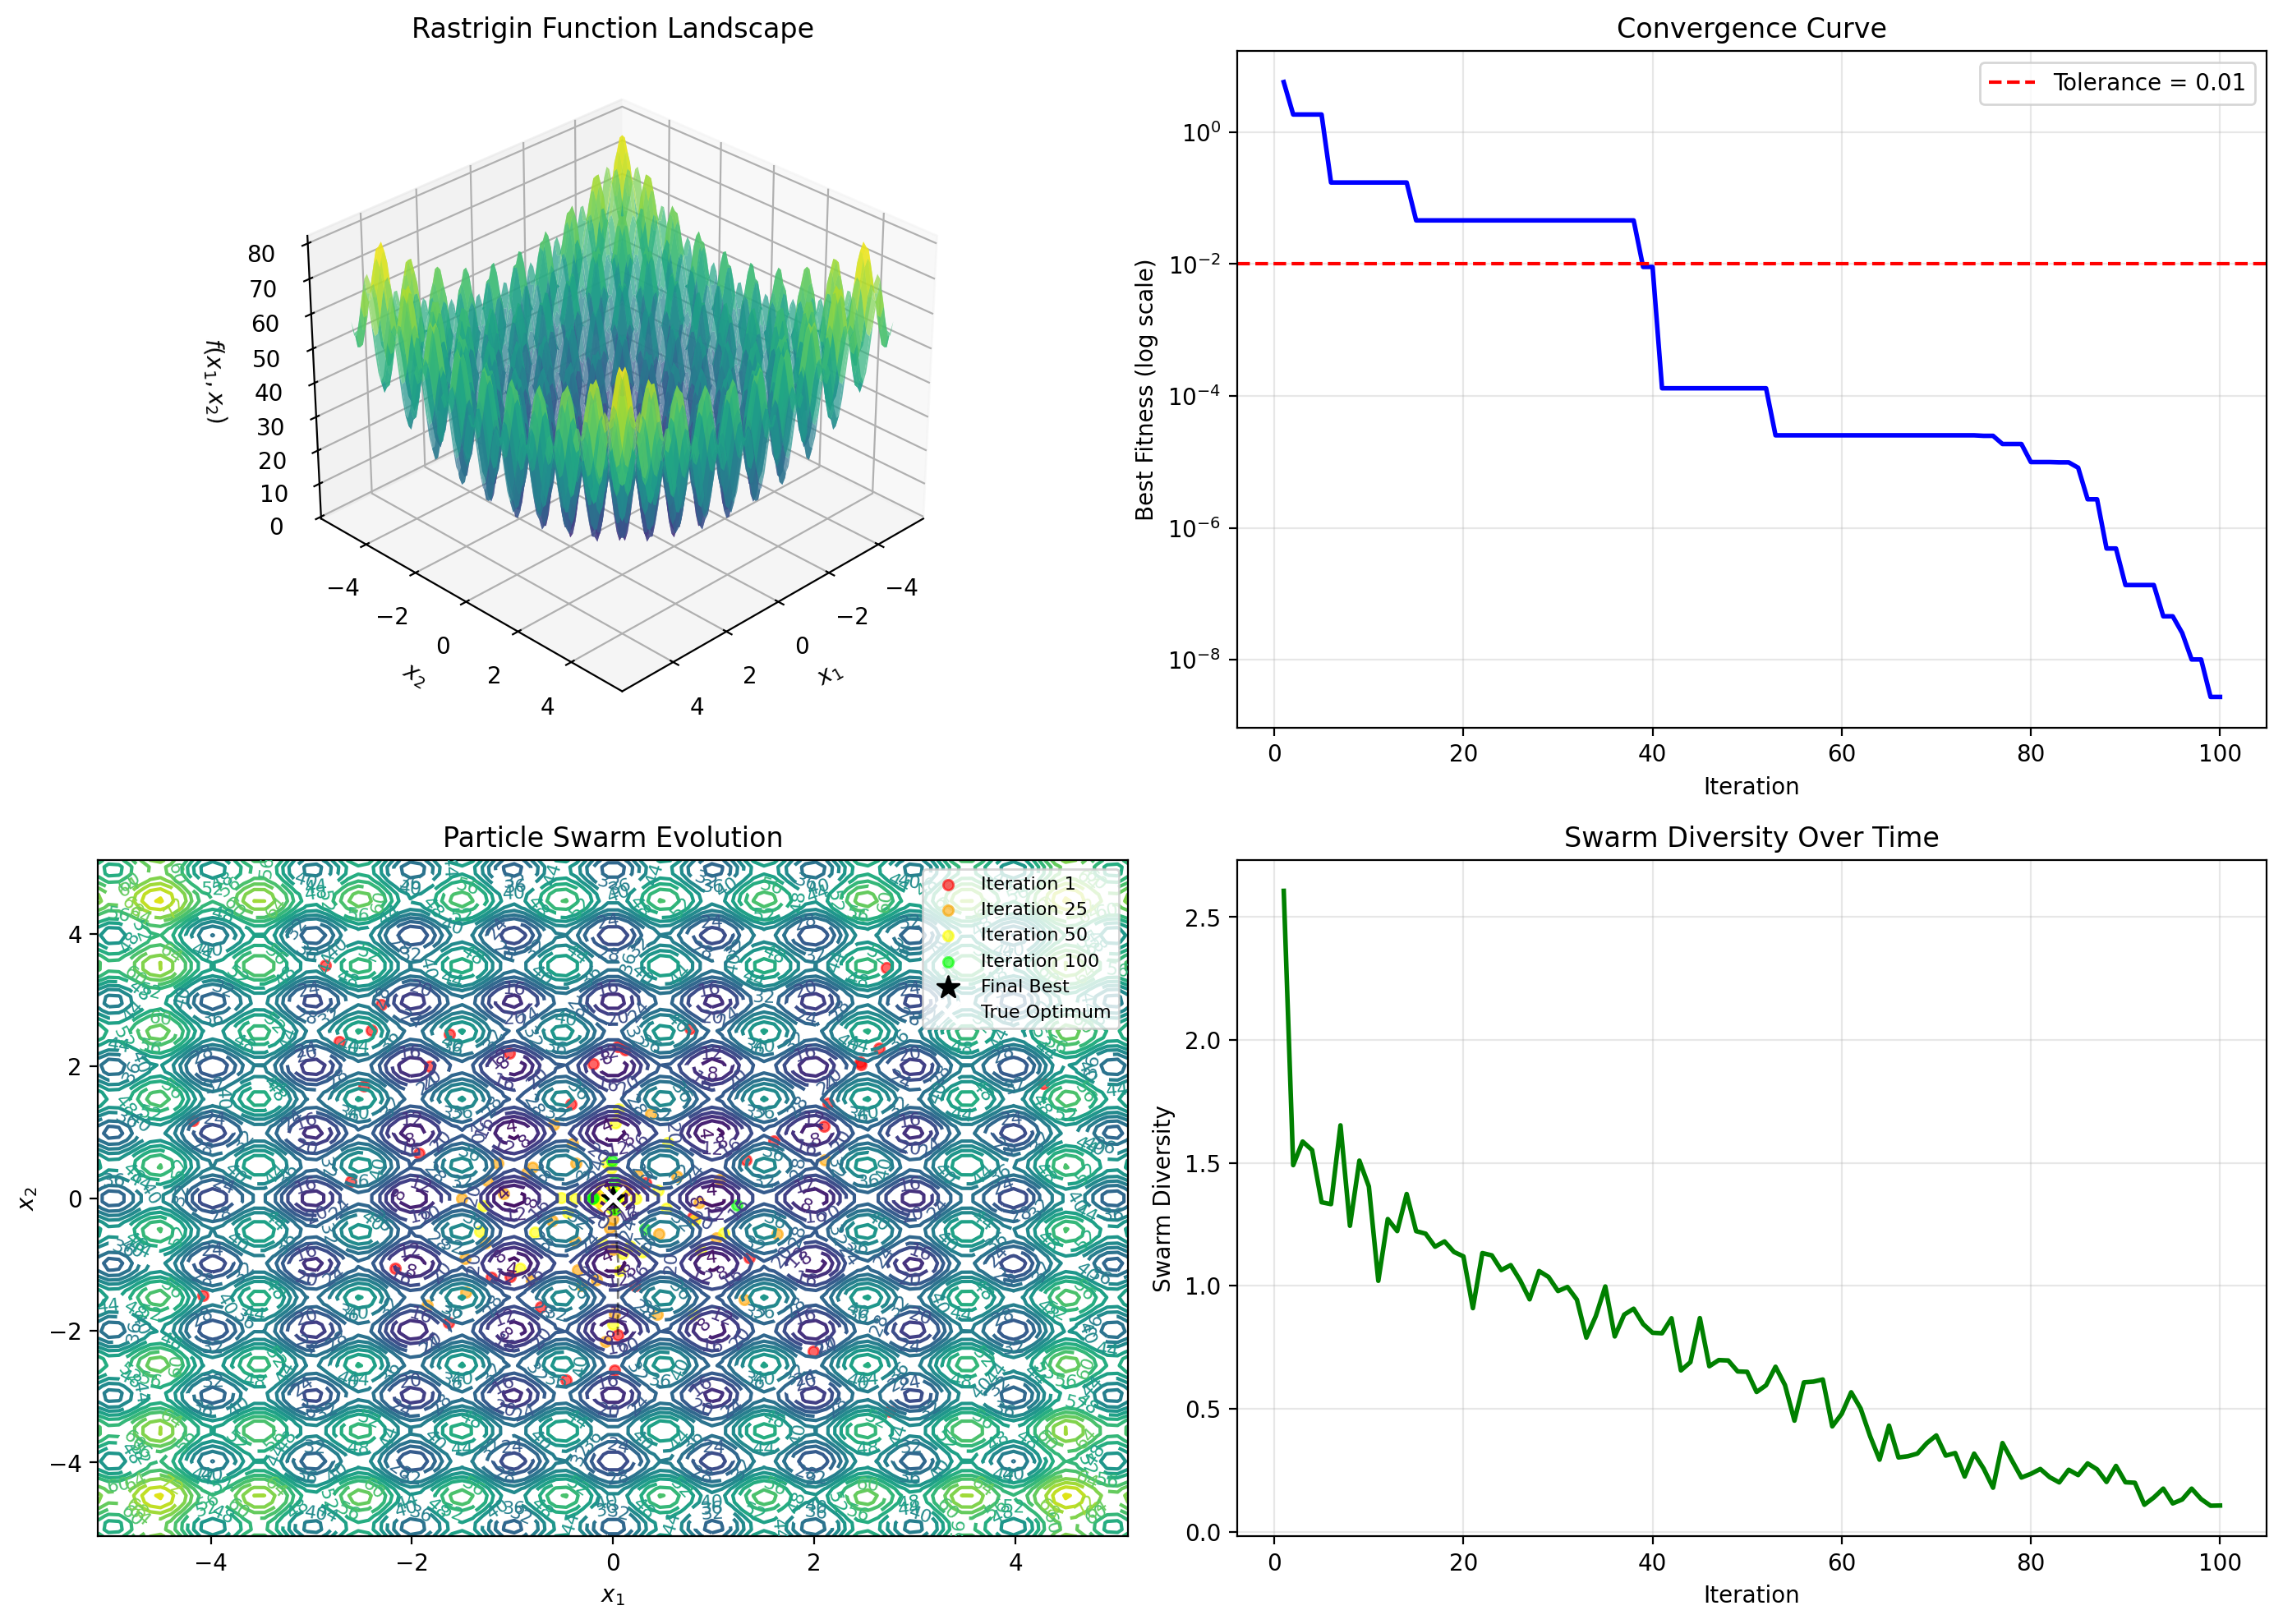


Plot saved to 'plot.png'


In [5]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(14, 10))

# Subplot 1: 3D surface plot of Rastrigin function
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
x = np.linspace(-5.12, 5.12, 100)
y = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(x, y)
Z = 10 * 2 + (X**2 - 10 * np.cos(2 * np.pi * X)) + (Y**2 - 10 * np.cos(2 * np.pi * Y))

surf = ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.7, linewidth=0)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$f(x_1, x_2)$')
ax1.set_title('Rastrigin Function Landscape')
ax1.view_init(elev=30, azim=45)

# Subplot 2: Convergence curve
ax2 = fig.add_subplot(2, 2, 2)
iterations = range(1, len(pso.history['global_best_fitness']) + 1)
ax2.semilogy(iterations, pso.history['global_best_fitness'], 'b-', linewidth=2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Best Fitness (log scale)')
ax2.set_title('Convergence Curve')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.01, color='r', linestyle='--', label='Tolerance = 0.01')
ax2.legend()

# Subplot 3: Contour plot with particle trajectories
ax3 = fig.add_subplot(2, 2, 3)
contour = ax3.contour(X, Y, Z, levels=20, cmap=cm.viridis)
ax3.clabel(contour, inline=True, fontsize=8)

# Plot particle positions at different iterations
iterations_to_plot = [0, 24, 49, 99]
colors = ['red', 'orange', 'yellow', 'lime']
for idx, it in enumerate(iterations_to_plot):
    if it < len(pso.history['positions']):
        positions = pso.history['positions'][it]
        ax3.scatter(positions[:, 0], positions[:, 1], c=colors[idx], 
                   s=20, alpha=0.6, label=f'Iteration {it+1}')

# Plot global best trajectory
gbest_history = np.array(pso.history['global_best_position'])
ax3.plot(gbest_history[:, 0], gbest_history[:, 1], 'k--', linewidth=1, alpha=0.5)
ax3.scatter(best_position[0], best_position[1], c='black', s=100, 
           marker='*', label='Final Best', zorder=5)
ax3.scatter(0, 0, c='white', s=100, marker='x', linewidths=2,
           label='True Optimum', zorder=5)

ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
ax3.set_title('Particle Swarm Evolution')
ax3.legend(loc='upper right', fontsize=8)
ax3.set_xlim(-5.12, 5.12)
ax3.set_ylim(-5.12, 5.12)

# Subplot 4: Swarm diversity over iterations
ax4 = fig.add_subplot(2, 2, 4)

# Calculate swarm diversity (average distance from swarm center)
diversity = []
for positions in pso.history['positions']:
    center = np.mean(positions, axis=0)
    distances = np.linalg.norm(positions - center, axis=1)
    diversity.append(np.mean(distances))

ax4.plot(iterations, diversity, 'g-', linewidth=2)
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Swarm Diversity')
ax4.set_title('Swarm Diversity Over Time')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('particle_swarm_optimization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis and Discussion

### Key Observations

1. **Convergence Behavior**: The convergence curve shows rapid initial improvement followed by gradual refinement. This is characteristic of PSO's exploration-exploitation balance.

2. **Swarm Diversity**: The diversity metric decreases over iterations, indicating that particles converge toward the global best. The linearly decreasing inertia weight facilitates this transition from exploration to exploitation.

3. **Parameter Sensitivity**: The performance of PSO is sensitive to parameter choices:
   - Higher $c_1$ promotes individual exploration
   - Higher $c_2$ promotes social learning
   - Inertia weight $w$ balances momentum and responsiveness

### Advantages of PSO

- **Simplicity**: Few parameters to tune compared to other metaheuristics
- **No gradient required**: Suitable for non-differentiable or noisy functions
- **Parallelizable**: Particle evaluations are independent
- **Memory**: Particles retain knowledge of personal and global bests

### Limitations

- **Premature convergence**: May converge to local optima in highly multimodal landscapes
- **No convergence guarantee**: Unlike gradient methods, no theoretical convergence proof
- **Parameter sensitivity**: Performance depends on proper tuning of $w$, $c_1$, $c_2$

### Extensions

Several variants address these limitations:
- **Adaptive PSO**: Dynamically adjusts parameters based on swarm behavior
- **Topology variants**: Ring, von Neumann, or dynamic topologies instead of global best
- **Hybrid methods**: Combine PSO with local search or other optimizers

## Conclusion

Particle Swarm Optimization provides an elegant and effective approach to continuous optimization problems. Its biologically-inspired mechanics—balancing individual experience with social information sharing—lead to robust search behavior across diverse problem landscapes.

The algorithm successfully minimized the Rastrigin function, a challenging multimodal benchmark, demonstrating its capability to escape local optima through swarm intelligence. The visualization reveals the characteristic behavior of PSO: initial exploration across the search space, followed by convergence as particles are attracted to promising regions.

For practitioners, PSO offers a good balance between simplicity and effectiveness, making it a valuable tool in the optimization toolkit alongside gradient-based methods and other metaheuristics.